In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from imutils import paths
import cv2
import os
import pickle as cPickle
from zipfile import ZipFile
from google.colab.patches import cv2_imshow

In [ ]:
!unzip -u "/content/drive/MyDrive/Colab Notebooks/Images/LC.zip" -d "/content/dataset"

Archive:  /content/drive/MyDrive/Colab Notebooks/Images/LC.zip


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Set the path to your dataset folder containing class subfolders
data_dir = "/content/dataset/images"

In [ ]:
# Image dimensions (adjust as needed based on your chosen architecture)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Batch size and number of epochs
batch_size = 32
epochs = 10

# Number of classes
num_classes = 2

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
# No data augmentation for validation set, just rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load and preprocess the data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
# Load pre-trained ResNet50 model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
# Add new top layers for our classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
# Freeze all layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10
7/7 [==============================] - 87s 13s/step - loss: 1.2749 - accuracy: 0.5050 - val_loss: 1.0800 - val_accuracy: 0.5000
Epoch 2/10
7/7 [==============================] - 82s 13s/step - loss: 1.0625 - accuracy: 0.4600 - val_loss: 0.7430 - val_accuracy: 0.5000
Epoch 3/10
7/7 [==============================] - 81s 13s/step - loss: 0.8100 - accuracy: 0.5200 - val_loss: 0.9670 - val_accuracy: 0.5000
Epoch 4/10
7/7 [==============================] - 80s 12s/step - loss: 0.8575 - accuracy: 0.5300 - val_loss: 0.8917 - val_accuracy: 0.5000
Epoch 5/10
7/7 [==============================] - 81s 12s/step - loss: 0.8002 - accuracy: 0.4450 - val_loss: 0.6675 - val_accuracy: 0.5700
Epoch 6/10
7/7 [==============================] - 81s 12s/step - loss: 0.7047 - accuracy: 0.5100 - val_loss: 0.6718 - val_accuracy: 0.5350
Epoch 7/10
7/7 [==============================] - 79s 12s/step - loss: 0.6767 - accuracy: 0.4900 - val_loss: 0.6529 - val_accuracy: 0.6500
Epoch 8/10
7/7 [===========

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

7/7 [==============================] - 39s 5s/step - loss: 0.6488 - accuracy: 0.6000
Validation Loss: 0.6487624645233154
Validation Accuracy: 0.6000000238418579


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Path to the single image you want to predict
image_path = "/content/dataset/images/Cheetahs/223fc16f8023cf96.jpg"


In [ ]:
# Load and preprocess the image
image = load_img(image_path, target_size=(img_width, img_height))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = preprocess_input(image_array)

# Make the prediction
prediction = model.predict(image_array)

1/1 [==============================] - 0s 193ms/step


In [ ]:
# Get the class index with the highest probability
predicted_class_index = np.argmax(prediction[0])

# Map the class index to the class label
class_labels = train_generator.class_indices
predicted_class_label = [k for k, v in class_labels.items() if v == predicted_class_index][0]

# Print the predicted class label and the probability
print("Predicted Class:", predicted_class_label)
print("Probability:", prediction[0][predicted_class_index])


Predicted Class: Cheetahs
Probability: 0.99999475


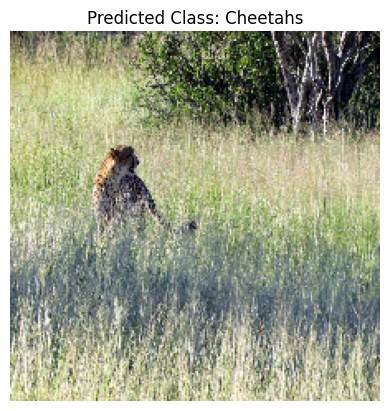

In [ ]:
# Display the image and its predicted class
plt.imshow(image)
plt.title("Predicted Class: " + predicted_class_label)
plt.axis("off")
plt.show()

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC

In [ ]:
# Load pre-trained ResNet50 model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

In [ ]:
# Function to extract HOG features from an image
def extract_hog_features(image_path):
    image = load_img(image_path, color_mode='rgb', target_size=(img_width, img_height))
    image_array = img_to_array(image)
    fd, _ = hog(image_array, visualize=True, multichannel=True)
    return fd

In [ ]:
# Function to extract features for all images in a given folder
def extract_features_from_folder(folder_path):
    features = []
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        fd = extract_hog_features(image_path)
        features.append(fd)
    return features

In [ ]:
# Extract features for training data
X_train = []
y_train = []
for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    class_features = extract_features_from_folder(class_path)
    X_train.extend(class_features)
    y_train.extend([0] * len(class_features) if class_folder == 'Lions' else [1] * len(class_features))


<ipython-input-91-833b5584eda0>:5: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, _ = hog(image_array, visualize=True, multichannel=True)


In [ ]:
# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Print the training accuracy
train_accuracy = svm_model.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.95777102
